In [25]:
# Instalează pachetele necesare (MONAI + cititor NIfTI)
# Folosim %pip pentru a ne asigura că se instalează în kernel-ul curent
%pip install monai nibabel

try:
    import nibabel
    print(f"✅ Nibabel instalat: {nibabel.__version__}")
except ImportError:
    print("❌ Nibabel nu a fost instalat corect.")

Note: you may need to restart the kernel to use updated packages.
✅ Nibabel instalat: 5.3.2



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import os
import pandas as pd
from torch.utils.data import Dataset
import monai
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    ScaleIntensityd,
    ToTensord,
)
print("Biblioteci importate cu succes!")

Biblioteci importate cu succes!


In [17]:
class LumiereDataset(Dataset):
    def __init__(self, csv_file, data_root, transform=None):
        self.data_root = data_root
        self.transform = transform
        
        # Citim CSV-ul
        self.df = pd.read_csv(csv_file)
        
        print(f"Coloane găsite în CSV: {self.df.columns.tolist()}")
        
        # Verificăm dacă avem coloanele necesare. Dacă nu, încercăm să le redenumim (fix pentru dataset-ul LUMIERE)
        if 'Rating' not in self.df.columns:
            print("⚠️ Coloana 'Rating' lipsește. Aplicăm redenumirea forțată a coloanelor (format LUMIERE).")
            # Aceasta este ordinea coloanelor din dataset-ul LUMIERE
            # Ne asigurăm că avem suficiente coloane
            if len(self.df.columns) >= 6:
                # Păstrăm doar primele 6 dacă sunt mai multe, sau le redenumim pe primele 6
                new_cols = ['Patient', 'Date', 'Less3Months', 'NonMeasurable', 'Rating', 'Rationale']
                # Dacă sunt mai multe coloane, le păstrăm numele vechi pentru restul
                if len(self.df.columns) > 6:
                    new_cols.extend(self.df.columns[6:])
                self.df.columns = new_cols
            else:
                print("❌ EROARE: CSV-ul nu are structura așteptată (minim 6 coloane).")
        
        # Curățăm datele (excludem rândurile fără Patient/Date)
        if 'Patient' in self.df.columns and 'Date' in self.df.columns:
            self.df = self.df.dropna(subset=['Patient', 'Date'])
        
        self.data_list = []
        self._prepare_data_list()

    def _prepare_data_list(self):
        print(f"Pregătesc lista de date din {self.data_root}...")
        valid_count = 0
        for index, row in self.df.iterrows():
            # Verificăm dacă coloanele există înainte de accesare
            if 'Patient' not in row or 'Date' not in row:
                continue
                
            patient_id = str(row['Patient']).strip()
            timepoint = str(row['Date']).strip()
            
            image_paths = self._get_image_path(patient_id, timepoint)
            
            if image_paths:
                # Verificăm dacă avem label
                label = row['Rating'] if 'Rating' in row else 0
                
                self.data_list.append({
                    "image": image_paths, # Lista de căi către fișiere
                    "label": label, # Rating-ul expertului
                    "patient": patient_id,
                    "timepoint": timepoint
                })
                valid_count += 1
        print(f"Am găsit {valid_count} vizite valide cu imagini.")

    def _get_image_path(self, patient_id, timepoint):
        """
        Găsește fișierele reale.
        Caută atât structura complexă (LUMIERE original) cât și cea simplă (Mock/Test).
        """
        visit_folder = os.path.join(self.data_root, patient_id, timepoint)
        target_dir = None
        
        if not os.path.exists(visit_folder):
            return None

        # Strategia 1: Căutăm structura complexă (HD-GLIO.../registered)
        for item in os.listdir(visit_folder):
            if "HD-GLIO" in item and "segmentation" in item:
                potential_path = os.path.join(visit_folder, item)
                if os.path.exists(os.path.join(potential_path, "REGISTRED")):
                    target_dir = os.path.join(potential_path, "REGISTRED")
                    break
                elif os.path.exists(os.path.join(potential_path, "registered")):
                    target_dir = os.path.join(potential_path, "registered")
                    break
        
        # Strategia 2: Căutăm structura simplă (direct în folder sau în 'registered')
        if target_dir is None:
            if os.path.exists(os.path.join(visit_folder, "registered")):
                target_dir = os.path.join(visit_folder, "registered")
            else:
                target_dir = visit_folder # Fișierele sunt direct în folderul vizitei

        # Definim lista de fișiere (Canalele Input)
        # Încercăm numele reale, apoi numele simple de test
        filenames_real = [
            "CT1_r2s_bet_reg.nii.gz", "FLAIR_r2s_bet_reg.nii.gz", 
            "T1_r2s_bet_reg.nii.gz", "T2_r2s_bet_reg.nii.gz"
        ]
        filenames_mock = [
            "T1_registered.nii.gz", "FLAIR_registered.nii.gz"
        ]
        
        # Verificăm care set de fișiere există
        selected_filenames = []
        if os.path.exists(os.path.join(target_dir, filenames_real[2])): # Verificăm T1 real
            selected_filenames = filenames_real
        elif os.path.exists(os.path.join(target_dir, filenames_mock[0])): # Verificăm T1 mock
            selected_filenames = filenames_mock
        else:
            return None # Nu am găsit niciun set valid de imagini

        full_paths = [os.path.join(target_dir, f) for f in selected_filenames]
        
        # Verificăm integritatea (toate fișierele trebuie să existe)
        for p in full_paths:
            if not os.path.exists(p):
                return None
            
        return full_paths

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        data = self.data_list[idx]
        if self.transform:
            data = self.transform(data)
        return data

In [18]:
# Testăm Dataset-ul
if __name__ == "__main__":
    import os
    import sys
    
    print(f"📂 Director curent (CWD): {os.getcwd()}")
    
    # Detectăm dacă suntem pe Google Colab
    is_colab = "/content" in os.getcwd()
    if is_colab:
        print("⚠️ ATENȚIE: Rulezi pe Google Colab (sau un container similar).")
        print("   Fișierele tale de pe D:\\ (Windows) NU sunt vizibile aici automat.")
    
    # Definim posibile locații ale dataset-ului
    possible_roots = [
        "../dataset", 
        "dataset",
        r"D:\study\licenta\creier\dataset",
        "/content/dataset",
        "/content/drive/MyDrive/dataset" # Dacă montezi Drive
    ]
    
    DATA_ROOT = None
    CSV_PATH = None
    
    for root in possible_roots:
        imaging_path = os.path.join(root, "LUMIERE", "Imaging")
        csv_candidate = os.path.join(root, "LUMIERE-ExpertRating.csv")
        
        if os.path.exists(imaging_path) and os.path.exists(csv_candidate):
            DATA_ROOT = imaging_path
            CSV_PATH = csv_candidate
            print(f"✅ Am găsit dataset-ul la: {root}")
            break

    if DATA_ROOT:
        print(f"🚀 Folosim dataset-ul din: {DATA_ROOT}")
        dataset = LumiereDataset(csv_file=CSV_PATH, data_root=DATA_ROOT)
        if len(dataset) > 0:
            print(f"✅ Dataset creat cu succes! Total elemente: {len(dataset)}")
            print("Exemplu item (căi imagini):", dataset[0]['image'])
        else:
            print("⚠️ Dataset-ul este gol.")
    else:
        print("\n❌ EROARE: Nu găsesc datele.")
        if is_colab:
            print("\n💡 SOLUȚIE PENTRU COLAB:")
            print("1. Schimbă Kernel-ul pe unul LOCAL (din VS Code, dreapta-sus).")
            print("   SAU")
            print("2. Dacă vrei să folosești Colab, trebuie să încarci datele.")
            print("   Poți monta Google Drive rulând celula de mai jos:")
            print("   from google.colab import drive")
            print("   drive.mount('/content/drive')")
        else:
            print("Verifică calea către dataset.")

📂 Director curent (CWD): d:\study\licenta\creier\scripts
✅ Am găsit dataset-ul la: ../dataset
🚀 Folosim dataset-ul din: ../dataset\LUMIERE\Imaging
Coloane găsite în CSV: ['Patient', 'Date', 'LessThan3Months', 'NonMeasurableLesions', 'Rating (according to RANO, PD: Progressive disease, SD: Stable disease, PR: Partial response, CR: Complete response, Pre-Op: Pre-Operative, Post-Op: Post-Operative)', 'Rating rationale (CRET: complete resection of the enhancing tumor, PRET: partial resection of the enhancing tumor, T2-Progr.: T2-Progression, L: Lesion)']
⚠️ Coloana 'Rating' lipsește. Aplicăm redenumirea forțată a coloanelor (format LUMIERE).
Pregătesc lista de date din ../dataset\LUMIERE\Imaging...
Am găsit 569 vizite valide cu imagini.
✅ Dataset creat cu succes! Total elemente: 569
Exemplu item (căi imagini): ['../dataset\\LUMIERE\\Imaging\\Patient-001\\week-000-1\\HD-GLIO-AUTO-segmentation\\registered\\CT1_r2s_bet_reg.nii.gz', '../dataset\\LUMIERE\\Imaging\\Patient-001\\week-000-1\\HD-GL

In [19]:
# Doar pentru Google Colab: Montează Drive-ul
# Decomentează liniile de mai jos dacă vrei să încarci datele din Drive
# from google.colab import drive
# drive.mount('/content/drive')

--- Vizualizare index 0 ---
Patient: Patient-001, Timepoint: week-000-1
Label (Rating): Pre-Op


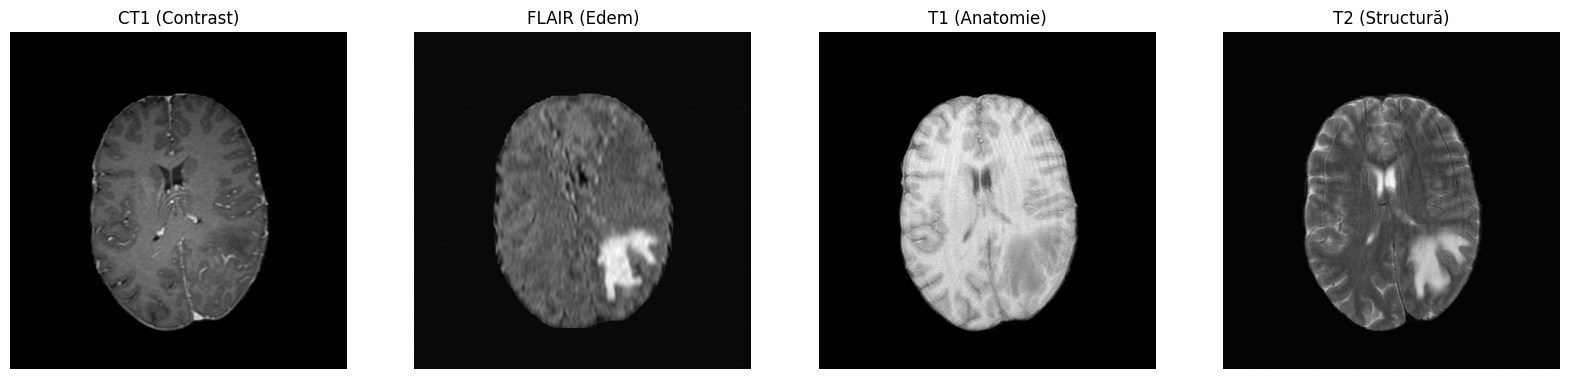

In [34]:
# Vizualizare date (Sanity Check)
# Asigură afișarea graficelor în notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import nibabel as nib
import os

def visualize_sample(dataset, index=0):
    print(f"--- Vizualizare index {index} ---")
    item = dataset[index]
    paths = item['image']
    label = item['label']
    
    print(f"Patient: {item['patient']}, Timepoint: {item['timepoint']}")
    print(f"Label (Rating): {label}")
    
    # Numele canalelor corespunzătoare ordinii din _get_image_path
    channel_names = ["CT1 (Contrast)", "FLAIR (Edem)", "T1 (Anatomie)", "T2 (Structură)"]
    
    plt.figure(figsize=(20, 5))
    for i, path in enumerate(paths):
        try:
            # Folosim calea absolută pentru siguranță
            abs_path = os.path.abspath(path)
            
            # Folosim direct nibabel pentru a evita problemele cu MONAI LoadImage
            # dacă backend-ul nu este detectat corect după instalare
            nimg = nib.load(abs_path)
            img = nimg.get_fdata()
            
            # Luăm felia din mijloc (axa Z) pentru a vedea creierul
            if len(img.shape) >= 3:
                mid_slice = img.shape[2] // 2
                # Gestionăm cazul în care avem 4 dimensiuni (ex: canale/timp)
                if len(img.shape) == 4:
                    img_slice = img[:, :, mid_slice, 0]
                else:
                    img_slice = img[:, :, mid_slice]
                
                plt.subplot(1, 4, i+1)
                # Rotim imaginea pentru a fi orientată corect (depinde de formatul NIfTI)
                plt.imshow(img_slice.T, cmap="gray", origin="lower")
                plt.title(channel_names[i])
                plt.axis("off")
            else:
                print(f"⚠️ Imaginea are dimensiuni neașteptate: {img.shape}")

        except Exception as e:
            print(f"❌ Eroare la încărcarea {path}: {e}")
            
    plt.show()

if __name__ == "__main__":
    # Verificăm dacă dataset-ul a fost creat anterior
    if 'dataset' in locals() and len(dataset) > 0:
        # Vizualizăm primul pacient
        visualize_sample(dataset, 0)
    else:
        print("⚠️ Nu există un dataset încărcat. Rulează celulele de mai sus.")

In [35]:
# DEBUG: Investigăm de ce nu se poate citi fișierul
import os
import nibabel as nib

# Luăm primul fișier din dataset pentru verificare
if 'dataset' in locals() and len(dataset) > 0:
    test_file_path = dataset[0]['image'][0] # Prima imagine din primul pacient
    
    print(f"🔍 Investigăm fișierul: {test_file_path}")
    abs_path = os.path.abspath(test_file_path)
    print(f"📂 Cale absolută: {abs_path}")

    if os.path.exists(test_file_path):
        size = os.path.getsize(test_file_path)
        print(f"📏 Dimensiune fișier: {size} bytes")
        
        if size < 1000:
            print("⚠️ ATENȚIE: Fișierul este foarte mic! Este posibil să fie un fișier text (mock) sau corupt.")
            try:
                with open(test_file_path, 'rb') as f:
                    content = f.read(100)
                    print(f"📄 Conținut (bytes): {content}")
            except Exception as e:
                print(f"Nu am putut citi conținutul: {e}")
        else:
            print("✅ Dimensiunea pare plauzibilă pentru un fișier NIfTI.")
            
        # Încercăm să citim direct cu nibabel pentru a vedea eroarea exactă
        print("\n🧪 Test citire directă cu nibabel...")
        try:
            img = nib.load(abs_path)
            print("✅ Succes! Nibabel a încărcat fișierul.")
            print(f"   Shape: {img.shape}")
            print(f"   Header: {img.header['sizeof_hdr']}")
        except Exception as e:
            print(f"❌ EROARE Nibabel: {e}")
            print("   Aceasta este cauza pentru care MONAI LoadImage eșuează.")
    else:
        print("❌ Fișierul nu există la calea specificată!")
else:
    print("⚠️ Nu există un dataset încărcat pentru a face debug.")

🔍 Investigăm fișierul: ../dataset\LUMIERE\Imaging\Patient-001\week-000-1\HD-GLIO-AUTO-segmentation\registered\CT1_r2s_bet_reg.nii.gz
📂 Cale absolută: d:\study\licenta\creier\dataset\LUMIERE\Imaging\Patient-001\week-000-1\HD-GLIO-AUTO-segmentation\registered\CT1_r2s_bet_reg.nii.gz
📏 Dimensiune fișier: 2401830 bytes
✅ Dimensiunea pare plauzibilă pentru un fișier NIfTI.

🧪 Test citire directă cu nibabel...
✅ Succes! Nibabel a încărcat fișierul.
   Shape: (640, 640, 24)
   Header: 348
